# 1.Cluster to find Centriods

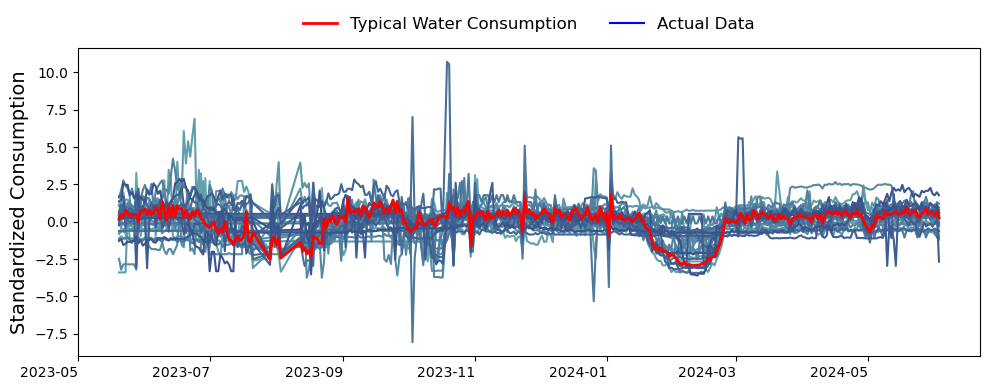

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn_extra.cluster import KMedoids
import tslearn.metrics as metrics

# -------------------------
# 1. 加载数据
# -------------------------
file_path = 'filled_structured_data.xlsx'
data = pd.read_excel(file_path)

# 假设数据第一列为非数值（例如日期或标识），其余列为数值数据
numeric_cols = data.columns[1:]

# -------------------------

# -------------------------
# 3. 对每一行的 NaN 值采用众数填充
# -------------------------
# -------------------------
# 3. 对每一行的 NaN 值采用填充
#    如果缺失值比例较低，采用移动窗口法填充；如果缺失值比例较高，则采用众数填充
# -------------------------
def fill_missing_with_moving_window(row, window=3, threshold=0.3):
    """
    如果 row 中缺失值比例低于 threshold，则采用移动窗口法填充缺失值，
    否则采用众数填充。
    移动窗口法：对每个缺失值，用其前后 window 个数据的均值进行填充。
    """
    missing_ratio = row.isna().mean()
    if missing_ratio > threshold:
        # 缺失值比例较高，采用众数填充
        return row.fillna(row.mode()[0])
    else:
        # 缺失值比例较低，采用移动窗口法填充
        row_filled = row.copy()
        for i in range(len(row)):
            if pd.isna(row[i]):
                # 确定窗口的起始和结束位置（保证索引不越界）
                start = max(0, i - window)
                end = min(len(row), i + window + 1)
                window_values = row[start:end]
                # 使用窗口内非缺失值的均值填充（如果窗口内全是NaN，则结果仍为NaN）
                row_filled.iloc[i] = window_values.mean()
        return row_filled

# 应用上述填充函数
numeric_data_filled = data[numeric_cols].apply(lambda row: fill_missing_with_moving_window(row, window=7, threshold=0.3), axis=1)
#将仍然存在的缺失值用众数填充
numeric_data_filled = numeric_data_filled.apply(lambda row: row.fillna(row.mode()[0]), axis=1)

# 将第一列（非数值）与填充后的数值数据合并
filled_with_mean = pd.concat([data.iloc[:, :1], numeric_data_filled], axis=1)


# -------------------------
# 4. 对数值数据进行标准化（逐行）
# -------------------------
numeric_data = filled_with_mean[numeric_cols]
normalized_data = numeric_data.apply(lambda row: (row - row.mean()) / row.std(), axis=1)
# 合并第一列和标准化后的数据
normalized_with_first_col = pd.concat([filled_with_mean.iloc[:, :1], normalized_data], axis=1)

# 此处后续操作使用标准化后的数值数据
data = normalized_data

# -------------------------
# 5. 使用KMedoids和软DTW进行聚类并可视化
# -------------------------
num_cluster = 1  # 假设选择1个聚类
km = KMedoids(n_clusters=num_cluster, random_state=0, metric="precomputed")

# 计算DTW距离矩阵（注意：data已经不包含第一列）
dists = metrics.cdist_soft_dtw_normalized(data.values, gamma=0.5)

# 聚类预测
y_pred = km.fit_predict(dists)

# 创建渐变色映射
cmap = mcolors.LinearSegmentedColormap.from_list("blue_gradient", ["#64A7AF", "#3A548C"], N=10)

plt.figure(figsize=(10, 4))  # 设置图表大小

# 对每个聚类中的样本绘制渐变颜色曲线
for yi in range(num_cluster):
    cluster_data = data[y_pred == yi]
    num_lines = len(cluster_data)
    for i, (index, row) in enumerate(cluster_data.iterrows()):
        color = cmap(i / num_lines)
        plt.plot(data.columns, row.values.ravel(), color=color, alpha=1)
    # 绘制聚类中心（medoid）
    medoid_idx = km.medoid_indices_[yi]
    plt.plot(data.columns, data.iloc[medoid_idx].values.ravel(), color="red", linewidth=2, label="Typical Water Consumption")
    # 将聚类中心保存到Excel文件中（可选）
    filled_with_mean.iloc[medoid_idx, 1:].to_excel(f'centers_{yi + 1}.xlsx')

# 添加图例
plt.plot([], [], color="blue", label="Actual Data")  # 空蓝线用于图例
plt.ylabel("Standardized Consumption", fontsize=14)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=12, frameon=False)

plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.show()


# 2. Prophet to decompose time centriods

Holidays DataFrame:   holiday         ds  lower_window  upper_window
0     节假日 2023-05-01             0             1
1     节假日 2023-05-02             0             1
2     节假日 2023-05-03             0             1
3     节假日 2023-06-22             0             1
4     节假日 2023-06-23             0             1,     holiday         ds  lower_window  upper_window
128     期末周 2024-01-17             0             1
129     期末周 2024-01-18             0             1
130     期末周 2024-01-19             0             1
131     期末周 2024-01-20             0             1
132     期末周 2024-01-21             0             1


20:32:15 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing


绘图数据已保存到 'plot_data.xlsx'
周季节性数据已保存到 'weekly_seasonality_data.xlsx'


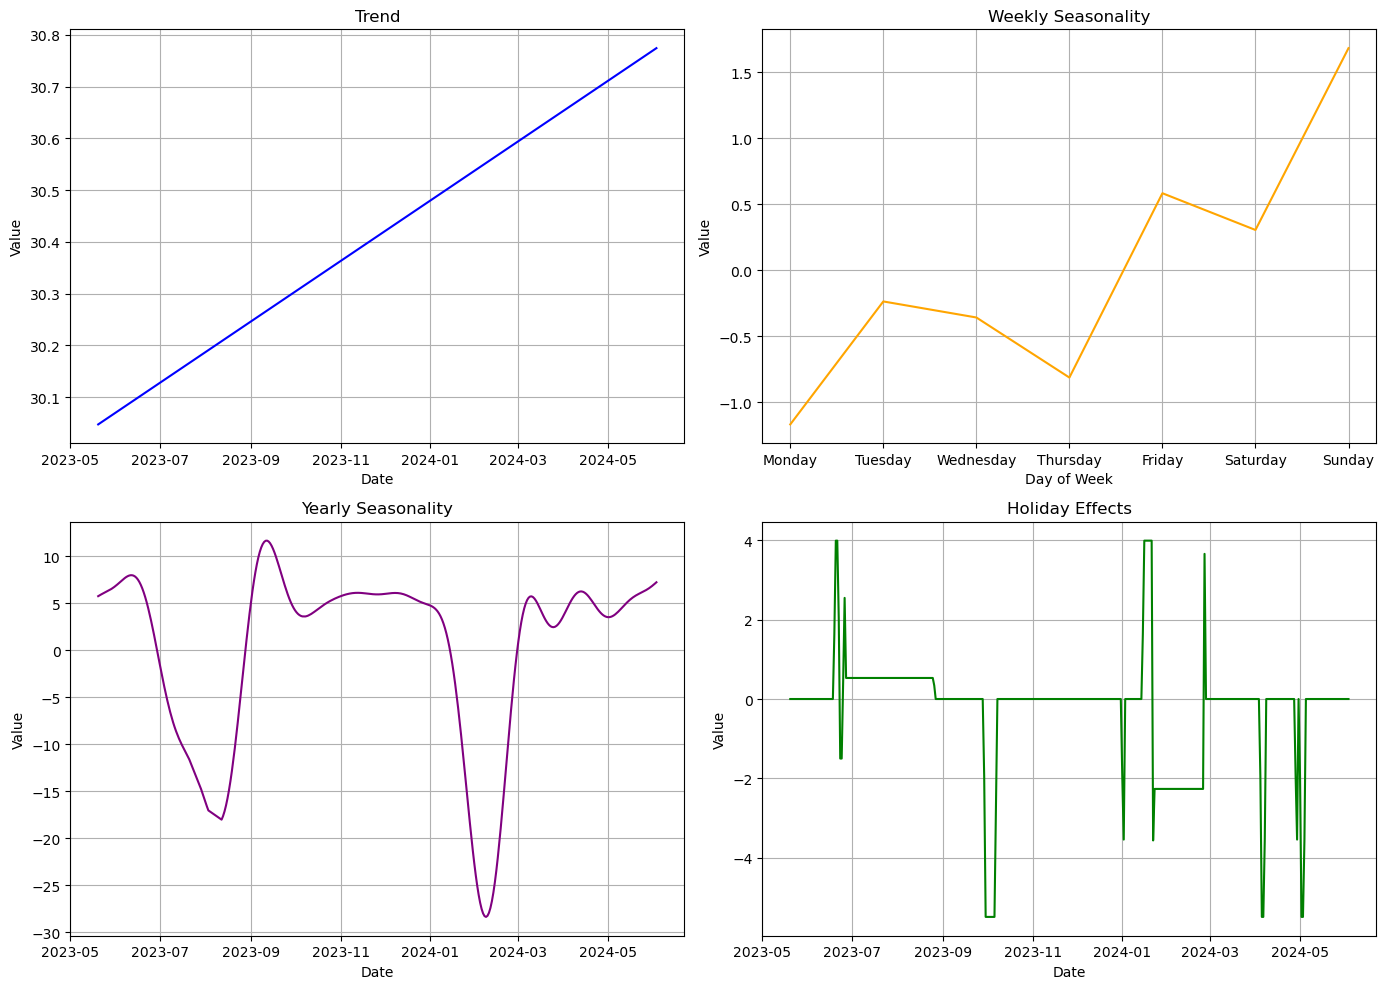

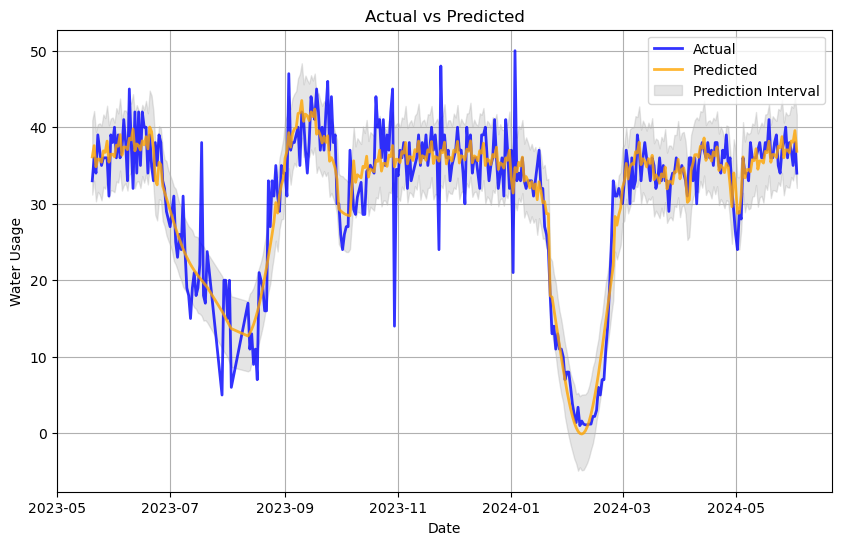

In [2]:
# 导入必要的库
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 加载数据
file_path = 'centers_1.xlsx'
data = pd.ExcelFile(file_path)
df = data.parse('Sheet1')

# 重命名列名
df.columns = ['date', 'water_usage']
df['date'] = pd.to_datetime(df['date'])
prophet_data = df.rename(columns={'date': 'ds', 'water_usage': 'y'})

# 动态生成节假日日期和对应的标签
holiday_dates = []

# 添加固定节假日
fixed_holidays = [
    '2023-05-01', '2023-05-02', '2023-05-03',  # 五一劳动节
    '2023-06-22', '2023-06-23', '2023-06-24',  # 端午节
    '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-03',
    '2023-10-04', '2023-10-05', '2023-10-06',  # 中秋节、国庆节
    '2024-01-01',  # 元旦
    '2024-04-04', '2024-04-05', '2024-04-06',  # 清明节
    '2024-05-01', '2024-05-02', '2024-05-03',  # 劳动节
    '2024-06-10',  # 端午节
    '2024-04-28'  # 校庆
]
holiday_labels = ['节假日'] * len(fixed_holidays)
holiday_dates.extend(pd.to_datetime(fixed_holidays))

# 添加暑假
summer_dates = pd.date_range(start='2023-06-26', end='2023-08-25')
holiday_labels.extend(['暑假'] * len(summer_dates))
holiday_dates.extend(summer_dates)

# 添加寒假
winter_dates = pd.date_range(start='2024-01-22', end='2024-02-25')
holiday_labels.extend(['寒假'] * len(winter_dates))
holiday_dates.extend(winter_dates)

# 添加期末周
exam_dates = pd.date_range(start='2023-06-19', end='2023-06-25').to_list() + \
             pd.date_range(start='2024-01-15', end='2024-01-21').to_list()
holiday_labels.extend(['期末周'] * len(exam_dates))
holiday_dates.extend(exam_dates)

# 创建节假日 DataFrame
holidays = pd.DataFrame({
    'holiday': holiday_labels,
    'ds': holiday_dates, 
    'lower_window': 0,
    'upper_window': 1  # 假期、考试周或校庆持续影响的天数
})

# 验证生成的 DataFrame（可选）
print(f"Holidays DataFrame: {holidays.head()}, {holidays.tail()}")

# 定义暑假、寒假和节假日条件
def is_summer_or_winter_or_holiday(ds):
    date = pd.to_datetime(ds)
    return (date in summer_dates) or (date in winter_dates) or (date in pd.to_datetime(fixed_holidays))


# 添加条件列（非暑假和寒假时才考虑周期性）
prophet_data['not_summer_winter'] = ~prophet_data['ds'].apply(is_summer_or_winter_or_holiday)

# 初始化 Prophet 模型
model = Prophet(weekly_seasonality=False, yearly_seasonality=True, holidays=holidays)

# 添加条件季节性（仅在非暑假和寒假时考虑每周周期性）
model.add_seasonality(name='weekly_not_summer_winter', period=7, fourier_order=3, condition_name='not_summer_winter')

# 拟合模型
model.fit(prophet_data)

# 对已有数据进行分解
forecast = model.predict(prophet_data)

# 创建用于绘图的数据 DataFrame
plot_data = pd.DataFrame({
    'date': forecast['ds'],
    'actual_values': prophet_data['y'],
    'predicted_values': forecast['yhat'],
    'trend': forecast['trend'],
    'yearly_seasonality': forecast['yearly'],
    'holidays_effect': forecast['holidays'] if 'holidays' in forecast.columns else 0,
    'prediction_lower': forecast['yhat_lower'],
    'prediction_upper': forecast['yhat_upper']
})

# 添加周季节性数据（如果存在）
if 'weekly_not_summer_winter' in forecast.columns:
    plot_data['weekly_seasonality'] = forecast['weekly_not_summer_winter']

# 将绘图数据保存到Excel文件
plot_data.to_excel('plot_data.xlsx', index=False)
print("绘图数据已保存到 'plot_data.xlsx'")

# 为周季节性数据创建单独的DataFrame（横坐标为周一到周日）
if 'weekly_not_summer_winter' in forecast.columns:
    # 获取一周的周期性效应
    days_of_week = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    weekly_values = forecast['weekly_not_summer_winter'][2:9]  # 一周的周期性值
    weekly_data = pd.DataFrame({
        'day_of_week': days_of_week,
        'weekly_effect': weekly_values
    })
    weekly_data.to_excel('weekly_seasonality_data.xlsx', index=False)
    print("周季节性数据已保存到 'weekly_seasonality_data.xlsx'")

# 手动绘制分解图
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 绘制趋势
axs[0, 0].plot(forecast['ds'], forecast['trend'], color='blue', label='Trend')
axs[0, 0].set_title('Trend')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Value')
axs[0, 0].grid()

# 绘制年季节性
axs[1, 0].plot(forecast['ds'], forecast['yearly'], color='purple', label='Yearly Seasonality')
axs[1, 0].set_title('Yearly Seasonality')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Value')
axs[1, 0].grid()

# 绘制周季节性（将横坐标设置为周一到周日）
if 'weekly_not_summer_winter' in forecast:
    # 提取周几和 weekly 值
    day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_values = forecast['weekly_not_summer_winter'][2:9]  # 一周的周期性值
    axs[0, 1].plot(day_of_week, weekly_values, color='orange', label='Weekly Seasonality')
    axs[0, 1].set_title('Weekly Seasonality')
    axs[0, 1].set_xlabel('Day of Week')
    axs[0, 1].set_ylabel('Value')
    axs[0, 1].grid()

# 绘制假日效应
if 'holidays' in forecast:
    axs[1, 1].plot(forecast['ds'], forecast['holidays'], color='green', label='Holiday Effects')
    axs[1, 1].set_title('Holiday Effects')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].grid()

# 调整布局
plt.tight_layout()

# 绘制真实值与预测值对比
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue', alpha=0.8, linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='orange', alpha=0.8, linewidth=2)
plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='gray', alpha=0.2, label='Prediction Interval'
)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Water Usage')
plt.legend()
plt.grid()

# 展示图表
plt.show()

In [6]:
# 检验上述Prophe模型的误差MAPE和RMSE、R2
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
# 计算 MAE 和 RMSE
mae = mean_absolute_error(prophet_data['y'], forecast['yhat'])
r2 = r2_score(prophet_data['y'], forecast['yhat'])
mape_value = mape(prophet_data['y'], forecast['yhat'])

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_value:.2f}%")


Mean Absolute Error: 2.62
R2 Score: 0.87
Mean Absolute Percentage Error (MAPE): 13.55%


# 3. Plot

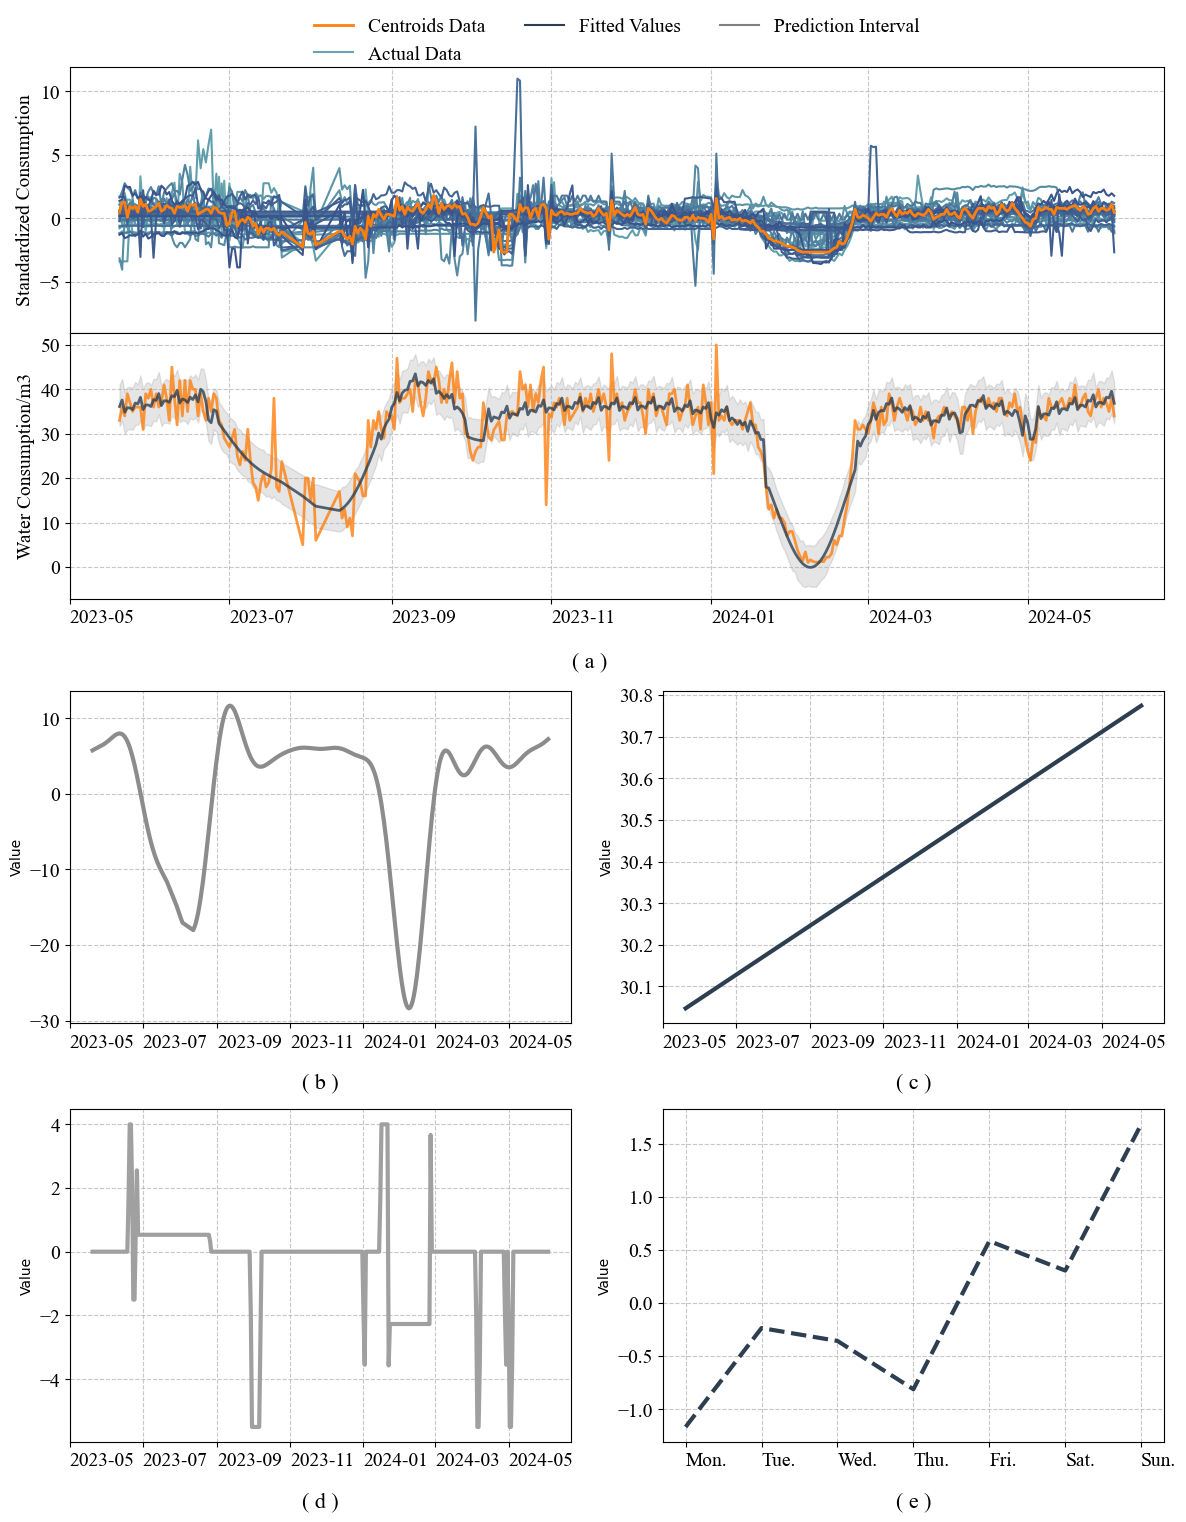

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sklearn_extra.cluster import KMedoids
import tslearn.metrics as metrics
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

# --------------------------
# 参数与字体设置
# --------------------------
# Times New Roman 字体（请确保路径正确）
font_properties = fm.FontProperties(fname='C:/Windows/Fonts/times.ttf', size=14)  # Windows 默认路径，确保路径正确

# --------------------------
# 创建整体画布（共6个子图）
# 上部2个子图（全宽），下部4个子图（2行×2列）
# 可通过 height_ratios 调整上部与下部的高度比例
fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(4, 2, height_ratios=[0.8, 0.8, 1, 1])

# 定义上部子图（全宽）
ax1 = fig.add_subplot(gs[0, :])  # 第一行，跨两列
ax2 = fig.add_subplot(gs[1, :], sharex=ax1)  # 第二行，跨两列，共享 x 轴
ax1.tick_params(labelbottom=False)  # 隐藏 ax1 的 x 轴标签

# 定义下部子图（2行2列）
# 这里我们按照原代码中 Prophet 分解图的顺序：
#   左上：Yearly Seasonality
#   右上：Trend
#   左下：Holiday Effects
#   右下：Weekly Seasonality
ax3 = fig.add_subplot(gs[2, 0])  # Yearly Seasonality
ax4 = fig.add_subplot(gs[2, 1])  # Trend
ax5 = fig.add_subplot(gs[3, 0])  # Holiday Effects
ax6 = fig.add_subplot(gs[3, 1])  # Weekly Seasonality

# ===========================
# Part 1: 水耗数据图 (上部2个子图)
# ===========================

# --- 上部数据处理及聚类 ---
file_path = 'filled_structured_data.xlsx'
data = pd.read_excel(file_path)

# 假设第一列为日期/标识，其余列为水耗数据
numeric_data_2 = data.iloc[:, 1:]
# 对每行采用众数填充缺失值（若众数为空则保持原样）
numeric_data_filled = numeric_data_2.apply(lambda row: row.fillna(row.mode().iloc[0]) if not row.mode().empty else row, axis=1)
filled_with_mean = pd.concat([data.iloc[:, :1], numeric_data_filled], axis=1)
numeric_data = filled_with_mean.iloc[:, 1:]
# 对数值数据逐行标准化
normalized_data = numeric_data.apply(lambda row: (row - row.mean()) / row.std(), axis=1)

# --- K-Medoids 聚类 ---
num_cluster = 1  # 假设只聚成1类
km = KMedoids(n_clusters=num_cluster, random_state=0, metric="precomputed")
dists = metrics.cdist_soft_dtw_normalized(normalized_data.values, gamma=0.5)
y_pred = km.fit_predict(dists)

# --- 绘制上部第1子图 (ax1): 所有实际样本曲线与聚类中心 ---
# 创建蓝色渐变色映射（实际数据）
cmap = mcolors.LinearSegmentedColormap.from_list("blue_gradient", ["#64A7AF", "#3A548C"], N=10)

for yi in range(num_cluster):
    cluster_data = normalized_data.iloc[y_pred == yi].values
    num_lines = len(cluster_data)
    for i, xx in enumerate(cluster_data):
        color = cmap(i / num_lines)
        # 这里x轴取所有数据的列名
        ax1.plot(normalized_data.columns, xx.ravel(), color=color, alpha=1)

# 绘制聚类中心，采用橙色 (#ff7f0e)
ax1.plot(normalized_data.columns,
         normalized_data.iloc[km.medoid_indices_[0]].values.ravel(),
         color="#ff7f0e", linewidth=2, label="Centroids Data")

# 添加虚拟线条生成图例
ax1.plot([], [], color="#64A7AF", label="Actual Data")
ax1.plot([], [], color="#2c3e50", label="Fitted Values")
ax1.plot([], [], color="gray", label="Prediction Interval")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3,
           fontsize=30, frameon=False, prop=font_properties)
ax1.set_ylabel("Standardized Consumption", fontsize=14, family='Times New Roman')
ax1.grid(True, linestyle='--', alpha=0.7)

# --- 绘制上部第2子图 (ax2): 实际 vs 拟合比较 ---
plot_data = pd.read_excel('plot_data.xlsx')

ax2.plot(plot_data['date'], plot_data['actual_values'],
         label='Typical Data', color="#ff7f0e", alpha=0.8, linewidth=2)
ax2.plot(plot_data['date'], plot_data['predicted_values'],
         label='Predicted Values', color='#2c3e50', alpha=0.8, linewidth=2)
ax2.fill_between(plot_data['date'],
                 plot_data['prediction_lower'],
                 plot_data['prediction_upper'],
                 color='gray', alpha=0.2, label='Prediction Interval')

ax2.set_ylabel('Water Consumption/m3', fontsize=14, family='Times New Roman')
ax2.grid(True, linestyle='--', alpha=0.7)

# 统一设置 x 轴标签和字体
for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), rotation=0, ha='left', family='Times New Roman')
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Times New Roman')


# ===========================
# Part 2: Prophet 分解图 (下部4个子图)
# ===========================

# 这里假设 Prophet 分解数据保存在 forecast 数据中
excel_file = 'plot_data.xlsx'  # 如有需要，可调整工作表或文件名
forecast = pd.read_excel(excel_file)  # 假设 forecast 数据中含有日期、trend、yearly_seasonality、weekly_seasonality、holidays_effect等列

# --- Yearly Seasonality (ax3) ---
ax3.plot(forecast['date'], forecast['yearly_seasonality'],
         color="#8c8c8c", linewidth=3, label='Yearly Seasonality')
ax3.set_ylabel('Value')
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Trend (ax4) ---
ax4.plot(forecast['date'], forecast['trend'],
         color="#2c3e50", linewidth=3, label='Trend')
ax4.set_ylabel('Value')
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Holiday Effects (ax5) ---
if 'holidays_effect' in forecast.columns:
    ax5.plot(forecast['date'], forecast['holidays_effect'],
             color="#a0a0a0", linewidth=3, label='Holiday Effects')
    ax5.set_ylabel('Value')
    ax5.grid(True, linestyle='--', alpha=0.7)
else:
    ax5.text(0.5, 0.5, 'No Holiday Effects data', ha='center', va='center')
    ax5.set_title('Holiday Effects')
    ax5.grid(True, linestyle='--', alpha=0.7)

# --- Weekly Seasonality (ax6) ---
if 'weekly_seasonality' in forecast.columns:
    day_of_week = ['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.']
    weekly_values = forecast['weekly_seasonality'][2:9].values
    ax6.plot(day_of_week, weekly_values,
             color="#2c3e50", linestyle='--', linewidth=3, label='Weekly Seasonality')
    ax6.set_ylabel('Value')
    ax6.grid(True, linestyle='--', alpha=0.7)
else:
    ax6.text(0.5, 0.5, 'No Weekly Seasonality data', ha='center', va='center')
    ax6.set_title('Weekly Seasonality')
    ax6.grid(True, linestyle='--', alpha=0.7)


# 统一设置下部4个子图的 x 轴字体
for ax in [ax3, ax4, ax5, ax6]:
    plt.setp(ax.get_xticklabels(), rotation=0, ha='left', family='Times New Roman')
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Times New Roman')

# 例如，移除 ax3.set_title('Yearly Seasonality')，改用 text() 放在下方
ax3.text(0.5, -0.15, "( b )", transform=ax3.transAxes,
         ha='center', va='top', fontsize=16, family='Times New Roman')

# 同理，对 ax4/ax5/ax6 也做类似操作
ax4.text(0.5, -0.15, "( c )", transform=ax4.transAxes,
         ha='center', va='top', fontsize=16, family='Times New Roman')

ax5.text(0.5, -0.15, "( d )", transform=ax5.transAxes,
         ha='center', va='top', fontsize=16, family='Times New Roman')

ax6.text(0.5, -0.15, "( e )", transform=ax6.transAxes,
         ha='center', va='top', fontsize=16, family='Times New Roman')

# 也可以给 ax2 添加一个下方“标题”
ax2.text(0.5, -0.2, "( a )          ", transform=ax2.transAxes,
         ha='center', va='top', fontsize=16, family='Times New Roman')

plt.tight_layout()

# 手动调整 ax2 位置，使 ax2 的上边界与 ax1 的下边界重合
pos1 = ax1.get_position()
pos2 = ax2.get_position()
# 设置 ax2 的新位置：x 和宽度保持不变，y0 设为 ax1 的 y0 - ax2 的高度
ax2.set_position([pos2.x0, pos1.y0 - pos2.height, pos2.width, pos2.height])

# 手动调整 ax3、ax4 位置，使它们与 ax2 的垂直间距更小
pos2 = ax2.get_position()
pos3 = ax3.get_position()
pos4 = ax4.get_position()

dy = 0.05  # 向上移动的量，可根据需要微调

# ax3 向上移动
ax3.set_position([
    pos3.x0,             # 保持 x0 不变
    pos3.y0 + dy,        # 向上移动 dy
    pos3.width,          # 宽度保持不变
    pos3.height          # 高度保持不变
])

# ax4 与 ax3 同行，因此也向上移动相同距离
ax4.set_position([
    pos4.x0,
    pos4.y0 + dy,
    pos4.width,
    pos4.height
])
# 获取 ax5 和 ax6 的原始位置
pos5 = ax5.get_position()
pos6 = ax6.get_position()

# 将 ax5 向上移动 dy
ax5.set_position([pos5.x0, pos5.y0 + dy, pos5.width, pos5.height])
# 将 ax6 向上移动 dy（与 ax5 同行，因此也采用相同的偏移量）
ax6.set_position([pos6.x0, pos6.y0 + dy, pos6.width, pos6.height])


plt.savefig('combined_figure.png', dpi=300, bbox_inches='tight')
plt.show()
